In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models

import os
import torch
import librosa

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datasetsresnet import AudioDataset

/home/wew016/.local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/wew016/.local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
# path to urban sound 8k
data_root = "/home/wew016/UrbanSound8K/"
# path to label
label_path = "/home/wew016/UrbanSound8K/metadata/UrbanSound8K.csv"  

In [4]:
def lr_schedule(epoch, init_lr):
    if epoch <20:
        return init_lr
    elif epoch>=20 and epoch<40:
        return init_lr/10
    elif epoch>=40 and epoch <80:
        return init_lr/100
    else:
        return init_lr/1000

In [5]:
def train(MAX_EPOCH = 100):

    eval_interval = 5
    
    # initialize dataset (feature can be "mfcc", "spec", "mel_raw")
    audio_dataset = AudioDataset(1, DataRoot=data_root, LabelPath=label_path, feature="spec", mode="train")

    # define lstm model
    cnn_model = models.resnet18(num_classes=10)

    # to gpu
    cnn_model = cnn_model.cuda()
    #print(cnn_model)
    # initialize dataloader
    data_loader = torch.utils.data.DataLoader(audio_dataset, batch_size=32, shuffle=True, num_workers=1)

    # loss function
    loss_fn = nn.CrossEntropyLoss().cuda()

    # lr
    learning_rate = 1e-3

    # initialize optimizer
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
    
    # initialize logger
    train_acc = []
    test_acc = []
    
    train_loss = []
    test_loss = []
    
    for epoch in range(MAX_EPOCH):
        # iterate through dataset
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_schedule(epoch, learning_rate)
            
        # initialize epoch stat
        correct_num = 0
        total_num = 0
        loss_sum = 0

        for idx, data in enumerate(data_loader):
            #print(idx)
            train_data, labels = data
            
            #train_data = train_data.type(torch.float32)/255
            
            # data to gpu
            train_data = train_data.cuda()
            labels = labels.cuda()

            prob = cnn_model(train_data)   
            loss = loss_fn(prob, labels)

            output = prob.argmax(1)
            
            loss_sum += loss.item()*float(labels.shape[0])
            correct_num += (output==labels).sum().double()
            total_num += float(labels.shape[0])

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
        train_acc.append(correct_num/total_num)
        train_loss.append(loss_sum/total_num)
        
        print("epoch: {} acc: {:.4} avg loss: {:.4f}".format(epoch, correct_num/total_num, loss_sum/total_num))
        
#         if epoch%5 == 4:

        a,b = test(cnn_model)
        test_acc.append(a)
        test_loss.append(b)
    
    
    plt.figure()
    plt.plot(np.arange(MAX_EPOCH), train_acc)
#     plt.plot(np.arange(eval_interval-1, MAX_EPOCH, eval_interval), test_acc)
    plt.plot(np.arange(MAX_EPOCH), test_acc)
    plt.title("accuracy")
    plt.legend(["train","val"])
    
    plt.figure()
    plt.plot(np.arange(MAX_EPOCH), train_loss)
#     plt.plot(np.arange(eval_interval-1, MAX_EPOCH, eval_interval), test_loss)
    plt.plot(np.arange(MAX_EPOCH), test_loss)
    plt.title("loss")
    plt.legend(["train","val"])

In [6]:
def test(model, ):
    test_dataset = AudioDataset(3, DataRoot=data_root, LabelPath=label_path, feature="spec", mode="test")
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=1)
    
    model.eval()

    loss_fn = nn.CrossEntropyLoss().cuda()
    
    correct_num = 0
    total_num = 0
    loss_sum = 0
    
    for idx, data in enumerate(test_loader):
        test_data, labels = data
        test_data = test_data.cuda()
        labels = labels.cuda()

        test_data = test_data.cuda()

        prob = model(test_data)   
        loss = loss_fn(prob, labels)
        
        output = prob.argmax(1)
        
        correct_num += (output==labels).sum().double()
        loss_sum += loss.item()*float(labels.shape[0])
        total_num += float(labels.shape[0])
        
    model.train()

    print("##Testing## epoch acc: {:.4}".format(correct_num/total_num))
    return correct_num/total_num, loss_sum/total_num

verify spec feature success
epoch: 0 acc: 0.4982 avg loss: 1.4066
verify spec feature success
##Testing## epoch acc: 0.5816
epoch: 1 acc: 0.6641 avg loss: 0.9387
verify spec feature success
##Testing## epoch acc: 0.5341
epoch: 2 acc: 0.7282 avg loss: 0.7695
verify spec feature success
##Testing## epoch acc: 0.787
epoch: 3 acc: 0.7706 avg loss: 0.6519
verify spec feature success
##Testing## epoch acc: 0.6627
epoch: 4 acc: 0.8138 avg loss: 0.5439
verify spec feature success
##Testing## epoch acc: 0.8173
epoch: 5 acc: 0.8257 avg loss: 0.5070
verify spec feature success
##Testing## epoch acc: 0.8357
epoch: 6 acc: 0.8425 avg loss: 0.4582
verify spec feature success
##Testing## epoch acc: 0.8486
epoch: 7 acc: 0.8614 avg loss: 0.4064
verify spec feature success
##Testing## epoch acc: 0.9059
epoch: 8 acc: 0.8771 avg loss: 0.3595
verify spec feature success
##Testing## epoch acc: 0.813
epoch: 9 acc: 0.8899 avg loss: 0.3290
verify spec feature success
##Testing## epoch acc: 0.8757
epoch: 10 acc:

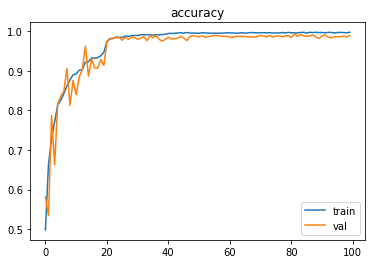

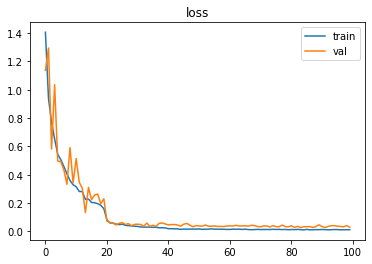

In [7]:
train(100)

In [8]:
159*0.9

143.1

In [7]:
np.arange(4,5,5)

array([4])